In [3]:
# Patient Sentiment Analysis - Training Pipeline
# Goal: Build a sentiment classifier for healthcare patient reviews

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import re
import nltk

# Download required NLTK data
import nltk
nltk.download('stopwords')
nltk.download('punkt')

print("Setup complete!")

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/malvinsiew/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/malvinsiew/nltk_data...


Setup complete!


[nltk_data]   Unzipping tokenizers/punkt.zip.


In [5]:
# Load dataset
df_train = pd.read_csv("../data/drugsComTrain_raw.csv")
df_test = pd.read_csv("../data/drugsComTest_raw.csv")

print("Training set shape:", df_train.shape)
print("Test set shape:", df_test.shape)
print("\nColumn names:")
print(df_train.columns.to_list())
print("\nFirst few rows:")
df_train.head()

Training set shape: (161297, 7)
Test set shape: (53766, 7)

Column names:
['uniqueID', 'drugName', 'condition', 'review', 'rating', 'date', 'usefulCount']

First few rows:


,uniqueID,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37


Rating distribution in training data:
rating
1     21619
2      6931
3      6513
4      5012
5      8013
6      6343
7      9456
8     18890
9     27531
10    50989
Name: count, dtype: int64


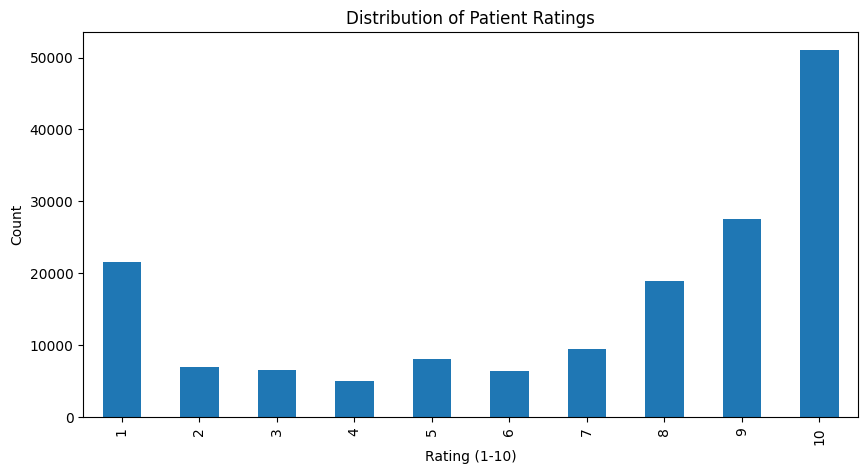


Mean rating: 6.99
Median rating: 8.0


In [14]:
# Explore the rating distribution
print("Rating distribution in training data:")
print(df_train['rating'].value_counts().sort_index())

# Visualise it
plt.figure(figsize=(10, 5))
df_train['rating'].value_counts().sort_index().plot(kind='bar')
plt.xlabel('Rating (1-10)')
plt.ylabel('Count')
plt.title('Distribution of Patient Ratings')
plt.show()

# Summary statistics
print(f"\nMean rating: {df_train['rating'].mean():.2f}")
print(f"Median rating: {df_train['rating'].median()}")

Training set sentiment distribution:
sentiment
0    35063
1    28824
2    97410
Name: count, dtype: int64

Percentages:
sentiment
0    21.73816
1    17.87014
2    60.39170
Name: proportion, dtype: float64


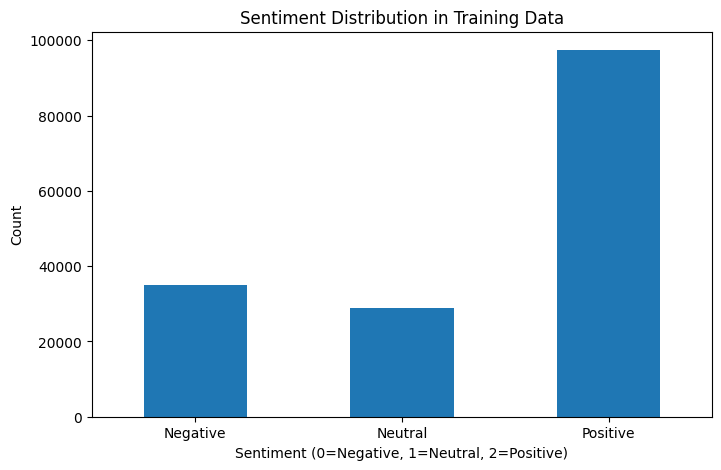

In [15]:
# Create sentiment labels based on rating
def rating_to_sentiment(rating):
    if rating <= 3:
        return 0  # Negative
    elif rating <= 7:
        return 1  # Neutral
    else:
        return 2  # Positive

# Apply to both train and test
df_train['sentiment'] = df_train['rating'].apply(rating_to_sentiment)
df_test['sentiment'] = df_test['rating'].apply(rating_to_sentiment)

# Check the distribution
print("Training set sentiment distribution:")
print(df_train['sentiment'].value_counts().sort_index())
print(f"\nPercentages:")
print(df_train['sentiment'].value_counts(normalize=True).sort_index() * 100)

# Visualize
plt.figure(figsize=(8, 5))
df_train['sentiment'].value_counts().sort_index().plot(kind='bar')
plt.xlabel('Sentiment (0=Negative, 1=Neutral, 2=Positive)')
plt.ylabel('Count')
plt.title('Sentiment Distribution in Training Data')
plt.xticks([0, 1, 2], ['Negative', 'Neutral', 'Positive'], rotation=0)
plt.show()

In [16]:
# Look at sample reviews from each sentiment class
print("=" * 80)
print("NEGATIVE REVIEWS (rating 1-3):")
print("=" * 80)
for review in df_train[df_train['sentiment'] == 0]['review'].head(3):
    print(f"- {review[:200]}...\n")

print("=" * 80)
print("NEUTRAL REVIEWS (rating 4-7):")
print("=" * 80)
for review in df_train[df_train['sentiment'] == 1]['review'].head(3):
    print(f"- {review[:200]}...\n")

print("=" * 80)
print("POSITIVE REVIEWS (rating 8-10):")
print("=" * 80)
for review in df_train[df_train['sentiment'] == 2]['review'].head(3):
    print(f"- {review[:200]}...\n")

NEGATIVE REVIEWS (rating 1-3):
- "2nd day on 5mg started to work with rock hard erections however experianced headache, lower bowel preassure. 3rd day erections would wake me up &amp; hurt! Leg/ankles aches   severe lower bowel preas...

- "He pulled out, but he cummed a bit in me. I took the Plan B 26 hours later, and took a pregnancy test two weeks later - - I&#039;m pregnant."...

- " I Ve had  nothing but problems with the Keppera : constant shaking in my arms &amp; legs &amp; pins &amp; needles feeling in my arms &amp; legs severe light headedness no appetite &amp; etc."...

NEUTRAL REVIEWS (rating 4-7):
- "I used to take another oral contraceptive, which had 21 pill cycle, and was very happy- very light periods, max 5 days, no other side effects. But it contained hormone gestodene, which is not availab...

- "I had Crohn&#039;s with a resection 30 years ago and have been mostly in remission since.  Have recently had a bad flare and narrowing at the anastomosis and need to be on m

In [19]:
import re
import html
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Download required NLTK data if not already done
import nltk
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)

# Modified stop words (excluding negations)
stop_words = set(stopwords.words('english'))
negation_words = {'no', 'not', 'nor', 'never', 'none', 'nobody', 'nothing', 
                  'neither', 'nowhere', 'hardly', 'scarcely', 'barely', "don't",
                  "doesn't", "didn't", "won't", "wouldn't", "shouldn't", "cannot",
                  "can't", "couldn't", "isn't", "aren't", "wasn't", "weren't"}
stop_words = stop_words - negation_words

def preprocess_text(text):
    """
    Clean and preprocess review text
    """
    # 1. Decode HTML entities
    text = html.unescape(text)
    
    # 2. Convert to lowercase
    text = text.lower()
    
    # 3. Remove URLs
    text = re.sub(r'http\S+|www\S+', '', text)
    
    # 4. Remove special characters, keep letters/numbers/spaces
    text = re.sub(r'[^a-z0-9\s]', ' ', text)
    
    # 5. Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    # 6. Remove stop words (but keep negations!)
    tokens = text.split()
    tokens = [word for word in tokens 
              if (word not in stop_words) and (len(word) > 2 or word in negation_words)]
    
    
    # 7. Join back
    cleaned_text = ' '.join(tokens)
    
    return cleaned_text

# Test again on same review
sample_review = df_train.iloc[0]['review']
print("ORIGINAL:")
print(sample_review)
print("\nCLEANED:")
print(preprocess_text(sample_review))

ORIGINAL:
"It has no side effect, I take it in combination of Bystolic 5 Mg and Fish Oil"

CLEANED:
no side effect take combination bystolic fish oil


In [20]:
# Apply preprocessing to all reviews
print("Preprocessing training data...")
df_train['cleaned_review'] = df_train['review'].apply(preprocess_text)

print("Preprocessing test data...")
df_test['cleaned_review'] = df_test['review'].apply(preprocess_text)

print("✓ Preprocessing complete!")

# Let's examine a few examples from each sentiment class
print("\n" + "="*80)
print("EXAMPLES OF CLEANED REVIEWS:")
print("="*80)

for sentiment, label in [(0, "NEGATIVE"), (1, "NEUTRAL"), (2, "POSITIVE")]:
    print(f"\n{label} (sentiment={sentiment}):")
    print("-"*80)
    sample = df_train[df_train['sentiment'] == sentiment].iloc[0]
    print(f"Original: {sample['review'][:150]}...")
    print(f"Cleaned:  {sample['cleaned_review'][:150]}...")

Preprocessing training data...
Preprocessing test data...
✓ Preprocessing complete!

EXAMPLES OF CLEANED REVIEWS:

NEGATIVE (sentiment=0):
--------------------------------------------------------------------------------
Original: "2nd day on 5mg started to work with rock hard erections however experianced headache, lower bowel preassure. 3rd day erections would wake me up &amp;...
Cleaned:  2nd day 5mg started work rock hard erections however experianced headache lower bowel preassure 3rd day erections would wake hurt leg ankles aches sev...

NEUTRAL (sentiment=1):
--------------------------------------------------------------------------------
Original: "I used to take another oral contraceptive, which had 21 pill cycle, and was very happy- very light periods, max 5 days, no other side effects. But it...
Cleaned:  used take another oral contraceptive pill cycle happy light periods max days no side effects contained hormone gestodene not available switched lybrel...

POSITIVE (sentimen

In [26]:
# Downloading Word2Vec for embedding
import gensim.downloader as api
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# Download pre-trained Word2Vec embeddings (this will take a few minutes first time)
print("Downloading Word2Vec embeddings (this may take a few minutes)...")
word2vec_model = api.load("word2vec-google-news-300")
print("✓ Word2Vec loaded successfully!")

# Check it works - test similarity
print("\nTesting embeddings:")
print(f"'good' is similar to: {word2vec_model.most_similar('good', topn=3)}")
print(f"'terrible' is similar to: {word2vec_model.most_similar('terrible', topn=3)}")


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.6 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "/Users/malvinsiew/miniconda3/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/Users/malvinsiew/miniconda3/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/Users/malvinsiew/PycharmProjects/Datascience/patient_sentiment_analysis/venv/lib/python3.10/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/Users/malvinsiew/PycharmProjects/Datascience/patient_sentiment_analysis/v

[--------------------------------------------------] 1.4% 23.4/1662.8MB downloaded

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[==------------------------------------------------] 5.3% 88.9/1662.8MB downloaded

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[====----------------------------------------------] 9.1% 151.5/1662.8MB downloaded

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[======--------------------------------------------] 12.7% 211.9/1662.8MB downloaded

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[========------------------------------------------] 16.7% 277.0/1662.8MB downloaded

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[==========----------------------------------------] 20.5% 341.2/1662.8MB downloaded

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[============--------------------------------------] 24.3% 403.3/1662.8MB downloaded

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[==============------------------------------------] 28.0% 465.8/1662.8MB downloaded

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[===============-----------------------------------] 31.9% 530.1/1662.8MB downloaded

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[=================---------------------------------] 35.6% 592.3/1662.8MB downloaded

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[===================-------------------------------] 39.4% 654.9/1662.8MB downloaded

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[=====================-----------------------------] 43.3% 719.9/1662.8MB downloaded

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[=======================---------------------------] 46.8% 778.9/1662.8MB downloaded

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[=========================-------------------------] 50.6% 841.2/1662.8MB downloaded

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[===========================-----------------------] 54.4% 904.6/1662.8MB downloaded

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[=============================---------------------] 58.1% 965.7/1662.8MB downloaded

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[==============================--------------------] 61.9% 1029.6/1662.8MB downloaded

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[================================------------------] 65.7% 1092.1/1662.8MB downloaded

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[==================================----------------] 69.6% 1156.6/1662.8MB downloaded

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[====================================--------------] 73.3% 1219.3/1662.8MB downloaded

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[======================================------------] 77.1% 1281.4/1662.8MB downloaded

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[========================================----------] 80.6% 1340.3/1662.8MB downloaded

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[==========================================--------] 84.1% 1398.6/1662.8MB downloaded

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[===========================================-------] 88.0% 1462.7/1662.8MB downloaded

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[=============================================-----] 91.9% 1527.3/1662.8MB downloaded

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[===============================================---] 95.6% 1590.2/1662.8MB downloaded

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[=================================================-] 99.4% 1652.3/1662.8MB downloaded

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)




✓ Word2Vec loaded successfully!

Testing embeddings:
'good' is similar to: [('great', 0.7291509509086609), ('bad', 0.7190050482749939), ('terrific', 0.688911497592926)]
'terrible' is similar to: [('horrible', 0.92439204454422), ('horrendous', 0.8467270135879517), ('dreadful', 0.8022767901420593)]


In [28]:
# Function to convert review to sequence of embeddings
def review_to_embedding_sequence(review, model, max_length=100, embedding_dim=300):
    """
    Convert a review to a sequence of word embeddings (padded/truncated to max_length)
    """
    words = review.split()
    
    # Get embedding for each word
    embeddings = []
    for word in words[:max_length]:  # Truncate if too long
        if word in model:
            embeddings.append(model[word])
        else:
            # Unknown word - use zero vector
            embeddings.append(np.zeros(embedding_dim))
    
    # Pad if too short
    while len(embeddings) < max_length:
        embeddings.append(np.zeros(embedding_dim))
    
    return np.array(embeddings)

# Test it
sample_review = df_train.iloc[0]['cleaned_review']
sample_sequence = review_to_embedding_sequence(sample_review, word2vec_model, max_length=100)

print(f"Sample review: {sample_review}")
print(f"\nSequence shape: {sample_sequence.shape}")  # Should be (100, 300)
print(f"This means: {sample_sequence.shape[0]} words × {sample_sequence.shape[1]} dimensions per word")

Sample review: no side effect take combination bystolic fish oil

Sequence shape: (100, 300)
This means: 100 words × 300 dimensions per word


In [ ]:
from tqdm import tqdm

# Convert all training reviews to embedding sequences
print("Converting training reviews to embeddings...")
X_train_embeddings = []
for review in tqdm(df_train['cleaned_review'], desc="Training set"):
    X_train_embeddings.append(review_to_embedding_sequence(review, word2vec_model, max_length=100))
X_train_embeddings = np.array(X_train_embeddings)

# Convert all test reviews
print("\nConverting test reviews to embeddings...")
X_test_embeddings = []
for review in tqdm(df_test['cleaned_review'], desc="Test set"):
    X_test_embeddings.append(review_to_embedding_sequence(review, word2vec_model, max_length=100))
X_test_embeddings = np.array(X_test_embeddings)

# Get labels
y_train = df_train['sentiment'].values
y_test = df_test['sentiment'].values

print(f"\n✓ Conversion complete!")
print(f"X_train shape: {X_train_embeddings.shape}")  # Should be (161297, 100, 300)
print(f"X_test shape: {X_test_embeddings.shape}")    # Should be (53766, 100, 300)
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")